In [25]:
import numpy as np
import matplotlib.pyplot as plt
%cd /home/jeroen/repos/traffic-scheduling/
from network.generate_network import generate_grid_network
from network.util import draw_network, plot_schedule
from network.exact import solve

/home/jeroen/repos/traffic-scheduling


Generate a grid-like network with routes from west to east and from south to north (to align with the usual x-y coordinate system).

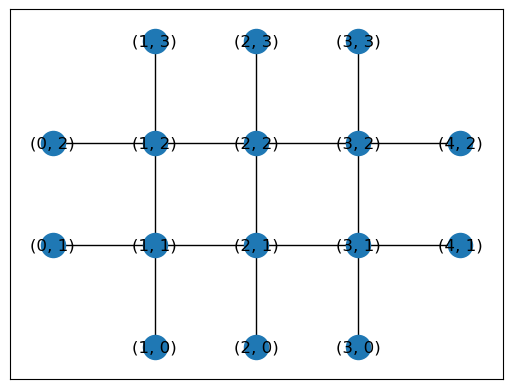

In [29]:
G, routes = generate_grid_network(3, 2)
draw_network(instance['G'])

Randomly generate vehicle arrivals and vehicle lengths.

In [32]:
vehicle_l = 2
vehicle_w = 1

N = len(routes)
n = [5 for _ in range(N)]

gap1 = 2
gap2 = 3

rng = np.random.default_rng()

def lane(n):
    length = np.repeat(vehicle_l, n)
    gaps = rng.uniform(gap1, gap2, size=(n))
    
    shifted = np.roll(length, 1); shifted[0] = 0
    release = np.cumsum(gaps + shifted)
    return release, length

releases, lengths = [], []
for l in range(N):
    rs, ls = lane(n[l])
    releases.append(rs); lengths.append(ls)

instance = {
    'G': G,
    'route': routes,
    'switch': vehicle_l - vehicle_w,
    'release': releases,
    'length': lengths,
}

Compute the optimal crossing times schedule by solving the network MILP.

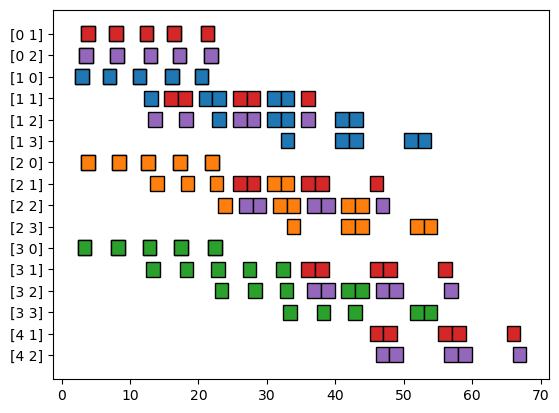

In [38]:
y, obj = solve(instance, consolelog=False, gap=0.00)
plot_schedule(instance, y)

Calculate the corresponding trajectories using the multi-checkpoint MotionSynthesize procedure and use these to generate a simple animation of the vehicle movements.

In [43]:
%%capture
from motion.motion import generate_trajectories
params = dict(vmax=1, umax=0.3, l=vehicle_l, dt=0.5)
trajectories = generate_trajectories(instance, y, params)

In [44]:
from motion.animation import animate
plt.rcParams["animation.html"] = "jshtml"
plt.ioff();
ani = animate(instance, trajectories, params['dt'], vehicle_l=vehicle_l)
ani.save(filename="grid.mp4", writer="ffmpeg")